# <div align="center">Implementing our network to classify digits</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

<img src="asset/1.6/main.png" />

Alright, let's write a program that learns how to recognize handwritten digits, using stochastic gradient descent and the MNIST training data. We'll do this with a short Python program, just 74 lines of code!

Incidentally, when I described the MNIST data earlier, I said it was split into 60,000 training images, and 10,000 test images. That's the official MNIST description. Actually, we're going to split the data a little differently. We'll leave the test images as is, but split the 60,000-image MNIST training set into two parts: a set of 50,000 images, which we'll use to train our neural network, and a separate 10,000 image validation set. We won't use the validation data in this chapter, but later in the book we'll find it useful in figuring out how to set certain hyper-parameters of the neural network - things like the learning rate, and so on, which aren't directly selected by our learning algorithm. Although the validation data isn't part of the original MNIST specification, many people use MNIST in this fashion, and the use of validation data is common in neural networks. When I refer to the "MNIST training data" from now on, I'll be referring to our 50,000 image data set, not the original 60,000 image data set.


Let me explain the core features of the neural networks code, before giving a full listing, below. The centerpiece is a Network class, which we use to represent a neural network. Here's the code we use to initialize a Network object:

In [1]:
import numpy as np

class Network:

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

In this code, the list sizes contains the number of neurons in the respective layers. So, for example, if we want to create a Network object with 2 neurons in the first layer, 3 neurons in the second layer, and 1 neuron in the final layer, we'd do this with the code:

In [15]:
net = Network([2, 3, 1])

The biases and weights in the Network object are all initialized randomly, using the Numpy np.random.randn function to generate Gaussian distributions with mean 0 and standard deviation 1. This random initialization gives our stochastic gradient descent algorithm a place to start from. In later chapters we'll find better ways of initializing the weights and biases, but this will do for now. Note that the Network initialization code assumes that the first layer of neurons is an input layer, and omits to set any biases for those neurons, since biases are only ever used in computing the outputs from later layers.

Note also that the biases and weights are stored as lists of Numpy matrices. So, for example net.weights[1] is a Numpy matrix storing the weights connecting the second and third layers of neurons. (It's not the first and second layers, since Python's list indexing starts at 0.) Since net.weights[1] is rather verbose, let's just denote that matrix w. It's a matrix such that wjk is the weight for the connection between the kth neuron in the second layer, and the jth neuron in the third layer. This ordering of the j and k indices may seem strange - surely it'd make more sense to swap the j and k indices around? The big advantage of using this ordering is that it means that the vector of activations of the third layer of neurons is:

<img src="asset/1.6/1.png" />

There's quite a bit going on in this equation, so let's unpack it piece by piece. a is the vector of activations of the second layer of neurons. To obtain a′ we multiply a by the weight matrix w, and add the vector b of biases. We then apply the function σ elementwise to every entry in the vector wa+b. (This is called vectorizing the function σ.) It's easy to verify that Equation (22) gives the same result as our earlier rule, Equation (4), for computing the output of a sigmoid neuron.



# <div align="center">Exercise</div>
---------------------------------------------------------------------
Write out Equation (22) in component form, and verify that it gives the same result as the rule (4) for computing the output of a sigmoid neuron.

Let's number the neurons in the $(l-1)^{th}$ layer $1 \leq k \leq K$, and the neurons in the $l^{th}$ layer $1 \leq j \leq J$.

$a' = \sigma(wa+b)$ implies for neuron $j$, by the rules of matrix multiplication:

$$\begin{aligned} a'_j &= \sigma\left(\sum\limits_{k=1}^{K} w_{jk} a_k + b_j\right) \\ a'_j &= \frac{1}{1 + exp(- \sum\limits_{k=1}^{K} w_{jk} a_k - b_j)} \end{aligned}$$
Which is the same as equation 4 in the book (with slightly different notations).

Recall the equation 4:

<img src="asset/1.6/2.png" />

With all this in mind, it's easy to write code computing the output from a Network instance. We begin by defining the sigmoid function:

In [16]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

Note that when the input z is a vector or Numpy array, Numpy automatically applies the function sigmoid elementwise, that is, in vectorized form.

We then add a feedforward method to the Network class, which, given an input a for the network, returns the corresponding output. All the method does is applies Equation (22) for each layer

In [18]:
def feedforward(self, a):
    """Return the output of the network if "a" is input."""
    for b, w in zip(self.biases, self.weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Of course, the main thing we want our Network objects to do is to learn. To that end we'll give them an SGD method which implements stochastic gradient descent. Here's the code. It's a little mysterious in a few places, but I'll break it down below, after the listing.

In [29]:
def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))

The training_data is a list of tuples (x, y) representing the training inputs and corresponding desired outputs. The variables epochs and mini_batch_size are what you'd expect - the number of epochs to train for, and the size of the mini-batches to use when sampling. eta is the learning rate, η. If the optional argument test_data is supplied, then the program will evaluate the network after each epoch of training, and print out partial progress. This is useful for tracking progress, but slows things down substantially.

The code works as follows. In each epoch, it starts by randomly shuffling the training data, and then partitions it into mini-batches of the appropriate size. This is an easy way of sampling randomly from the training data. Then for each mini_batch we apply a single step of gradient descent. This is done by the code self.update_mini_batch(mini_batch, eta), which updates the network weights and biases according to a single iteration of gradient descent, using just the training data in mini_batch. Here's the code for the update_mini_batch method:

In [30]:
def update_mini_batch(self, mini_batch, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The "mini_batch" is a list of tuples "(x, y)", and "eta"
    is the learning rate."""
    
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(eta/len(mini_batch))*nw 
                    for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch))*nb 
                   for b, nb in zip(self.biases, nabla_b)]

Most of the work is done by the line

In [32]:
delta_nabla_b, delta_nabla_w = self.backprop(x, y)

This invokes something called the backpropagation algorithm, which is a fast way of computing the gradient of the cost function. So update_mini_batch works simply by computing these gradients for every training example in the mini_batch, and then updating self.weights and self.biases appropriately.

I'm not going to show the code for self.backprop right now. We'll study how backpropagation works in the next chapter, including the code for self.backprop. For now, just assume that it behaves as claimed, returning the appropriate gradient for the cost associated to the training example x.

Let's look at the full program, including the documentation strings, which I omitted above. Apart from self.backprop the program is self-explanatory - all the heavy lifting is done in self.SGD and self.update_mini_batch, which we've already discussed. The self.backprop method makes use of a few extra functions to help in computing the gradient, namely sigmoid_prime, which computes the derivative of the σ function, and self.cost_derivative, which I won't describe here. You can get the gist of these (and perhaps the details) just by looking at the code and documentation strings. We'll look at them in detail in the next chapter. Note that while the program appears lengthy, much of the code is documentation strings intended to make the code easy to understand. In fact, the program contains just 74 lines of non-whitespace, non-comment code.

In [115]:
"""
network.py
~~~~~~~~~~
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

How well does the program recognize handwritten digits? Well, let's start by loading in the MNIST data.

In [37]:
# from sklearn.datasets import fetch_mldata

# mnist = fetch_mldata('MNIST original',data_home= 'C:/_Files/MyProjects/ASDS_2/DeepLearning/Intro_to_nn/input/1.6' )

In [66]:
"""
mnist_loader
~~~~~~~~~~~~

A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
# import cPickle
import pickle as cPickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
#     f = gzip.open('data/mnist.pkl.gz', 'rb')
#     training_data, validation_data, test_data = cPickle.load(f)
#     f.close()
    with gzip.open('data/mnist.pkl.gz', 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        p = u.load()
        training_data, validation_data, test_data = p
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [91]:
# import mnist_loader
training_data, validation_data, test_data = load_data_wrapper()

In [89]:
# # import mnist_loader
# training_data, validation_data, test_data = load_data()

In [90]:
# len(training_data[0][0])

In [92]:
training_data = list(training_data)
test_data = list(test_data)
validation_data = list(validation_data)

In [104]:
np.shape(training_data)

(50000, 2)

In [105]:
training_data[0][1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [110]:
# training_data[0][0]

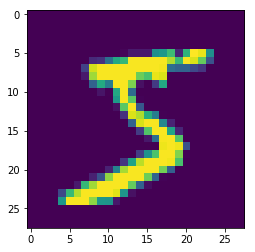

In [109]:
from matplotlib import pyplot as plt
plt.imshow(training_data[0][0].reshape(28,28));

In [116]:
net = Network([784, 30, 10])

Finally, we'll use stochastic gradient descent to learn from the MNIST training_data over 30 epochs, with a mini-batch size of 10, and a learning rate of η=3.0,

In [117]:
net.SGD(training_data, 30, 10, 0.001, test_data=test_data)

Epoch 0: 1259 / 10000
Epoch 1: 1718 / 10000
Epoch 2: 2011 / 10000
Epoch 3: 2177 / 10000
Epoch 4: 2329 / 10000
Epoch 5: 2420 / 10000
Epoch 6: 2496 / 10000
Epoch 7: 2572 / 10000
Epoch 8: 2654 / 10000
Epoch 9: 2711 / 10000
Epoch 10: 2778 / 10000
Epoch 11: 2824 / 10000
Epoch 12: 2873 / 10000
Epoch 13: 2930 / 10000
Epoch 14: 2996 / 10000
Epoch 15: 3053 / 10000
Epoch 16: 3108 / 10000
Epoch 17: 3169 / 10000
Epoch 18: 3229 / 10000
Epoch 19: 3289 / 10000
Epoch 20: 3337 / 10000
Epoch 21: 3390 / 10000
Epoch 22: 3445 / 10000
Epoch 23: 3495 / 10000
Epoch 24: 3548 / 10000
Epoch 25: 3605 / 10000
Epoch 26: 3635 / 10000
Epoch 27: 3700 / 10000
Epoch 28: 3758 / 10000
Epoch 29: 3815 / 10000


In [118]:
net.SGD(training_data, 30, 10, 0.01, test_data=test_data)

Epoch 0: 4290 / 10000
Epoch 1: 4665 / 10000
Epoch 2: 4954 / 10000
Epoch 3: 5224 / 10000
Epoch 4: 5451 / 10000
Epoch 5: 5644 / 10000
Epoch 6: 5843 / 10000
Epoch 7: 6017 / 10000
Epoch 8: 6206 / 10000
Epoch 9: 6369 / 10000
Epoch 10: 6534 / 10000
Epoch 11: 6704 / 10000
Epoch 12: 6865 / 10000
Epoch 13: 6978 / 10000
Epoch 14: 7103 / 10000
Epoch 15: 7208 / 10000
Epoch 16: 7301 / 10000
Epoch 17: 7381 / 10000
Epoch 18: 7458 / 10000
Epoch 19: 7542 / 10000
Epoch 20: 7603 / 10000
Epoch 21: 7668 / 10000
Epoch 22: 7730 / 10000
Epoch 23: 7778 / 10000
Epoch 24: 7822 / 10000
Epoch 25: 7859 / 10000
Epoch 26: 7896 / 10000
Epoch 27: 7921 / 10000
Epoch 28: 7958 / 10000
Epoch 29: 8001 / 10000


In [120]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 9050 / 10000
Epoch 1: 9257 / 10000
Epoch 2: 9273 / 10000
Epoch 3: 9293 / 10000
Epoch 4: 9328 / 10000
Epoch 5: 9375 / 10000
Epoch 6: 9390 / 10000
Epoch 7: 9398 / 10000
Epoch 8: 9395 / 10000
Epoch 9: 9410 / 10000
Epoch 10: 9460 / 10000
Epoch 11: 9382 / 10000
Epoch 12: 9446 / 10000
Epoch 13: 9444 / 10000
Epoch 14: 9431 / 10000
Epoch 15: 9484 / 10000
Epoch 16: 9439 / 10000
Epoch 17: 9477 / 10000
Epoch 18: 9437 / 10000
Epoch 19: 9453 / 10000
Epoch 20: 9482 / 10000
Epoch 21: 9463 / 10000
Epoch 22: 9489 / 10000
Epoch 23: 9474 / 10000
Epoch 24: 9481 / 10000
Epoch 25: 9483 / 10000
Epoch 26: 9490 / 10000
Epoch 27: 9470 / 10000
Epoch 28: 9459 / 10000
Epoch 29: 9485 / 10000


Now imagine that we were coming to this problem for the first time. Of course, we know from our earlier experiments that the right thing to do is to decrease the learning rate. But if we were coming to this problem for the first time then there wouldn't be much in the output to guide us on what to do. We might worry not only about the learning rate, but about every other aspect of our neural network. We might wonder if we've initialized the weights and biases in a way that makes it hard for the network to learn? Or maybe we don't have enough training data to get meaningful learning? Perhaps we haven't run for enough epochs? Or maybe it's impossible for a neural network with this architecture to learn to recognize handwritten digits? Maybe the learning rate is too low? Or, maybe, the learning rate is too high? When you're coming to a problem for the first time, you're not always sure.

The lesson to take away from this is that debugging a neural network is not trivial, and, just as for ordinary programming, there is an art to it. You need to learn that art of debugging in order to get good results from neural networks. More generally, we need to develop heuristics for choosing good hyper-parameters and a good architecture. We'll discuss all these at length through the book, including how I chose the hyper-parameters above.

I said above that our program gets pretty good results. What does that mean? Good compared to what? It's informative to have some simple (non-neural-network) baseline tests to compare against, to understand what it means to perform well. The simplest baseline of all, of course, is to randomly guess the digit. That'll be right about ten percent of the time. We're doing much better than that!

What about a less trivial baseline? Let's try an extremely simple idea: we'll look at how dark an image is. For instance, an image of a 2 will typically be quite a bit darker than an image of a 1, just because more pixels are blackened out, as the following examples illustrate:

This suggests using the training data to compute average darknesses for each digit, 0,1,2,…,9. When presented with a new image, we compute how dark the image is, and then guess that it's whichever digit has the closest average darkness. This is a simple procedure, and is easy to code up but it's a big improvement over random guessing, getting 2,225 of the 10,000 test images correct, i.e., 22.25 percent accuracy.

In [125]:
"""
mnist_average_darkness
~~~~~~~~~~~~~~~~~~~~~~

A naive classifier for recognizing handwritten digits from the MNIST
data set.  The program classifies digits based on how dark they are
--- the idea is that digits like "1" tend to be less dark than digits
like "8", simply because the latter has a more complex shape.  When
shown an image the classifier returns whichever digit in the training
data had the closest average darkness.

The program works in two steps: first it trains the classifier, and
then it applies the classifier to the MNIST test data to see how many
digits are correctly classified.

Needless to say, this isn't a very good way of recognizing handwritten
digits!  Still, it's useful to show what sort of performance we get
from naive ideas."""

#### Libraries
# Standard library
from collections import defaultdict

def main():
    training_data, validation_data, test_data = load_data()
    # training phase: compute the average darknesses for each digit,
    # based on the training data
    avgs = avg_darknesses(training_data)
    # testing phase: see how many of the test images are classified
    # correctly
    num_correct = sum(int(guess_digit(image, avgs) == digit)
                      for image, digit in zip(test_data[0], test_data[1]))
    print ("Baseline classifier using average darkness of image.")
    print ("%s of %s values correct." % (num_correct, len(test_data[1])))

def avg_darknesses(training_data):
    """ Return a defaultdict whose keys are the digits 0 through 9.
    For each digit we compute a value which is the average darkness of
    training images containing that digit.  The darkness for any
    particular image is just the sum of the darknesses for each pixel."""
    digit_counts = defaultdict(int)
    darknesses = defaultdict(float)
    for image, digit in zip(training_data[0], training_data[1]):
        digit_counts[digit] += 1
        darknesses[digit] += sum(image)
    avgs = defaultdict(float)
    for digit, n in digit_counts.items():
        avgs[digit] = darknesses[digit] / n
    return avgs

def guess_digit(image, avgs):
    """Return the digit whose average darkness in the training data is
    closest to the darkness of ``image``.  Note that ``avgs`` is
    assumed to be a defaultdict whose keys are 0...9, and whose values
    are the corresponding average darknesses across the training data."""
    darkness = sum(image)
    distances = {k: abs(v-darkness) for k, v in avgs.items()}
    return min(distances, key=distances.get)

main()

Baseline classifier using average darkness of image.
2225 of 10000 values correct.


It's not difficult to find other ideas which achieve accuracies in the 20 to 50 percent range. If you work a bit harder you can get up over 50 percent. But to get much higher accuracies it helps to use established machine learning algorithms. Let's try using one of the best known algorithms, the support vector machine or SVM. If you're not familiar with SVMs, not to worry, we're not going to need to understand the details of how SVMs work. Instead, we'll use a Python library called scikit-learn, which provides a simple Python interface to a fast C-based library for SVMs known as LIBSVM.

If we run scikit-learn's SVM classifier using the default settings, then it gets 9,435 of 10,000 test images correct.
That's a big improvement over our naive approach of classifying an image based on how dark it is. Indeed, it means that the SVM is performing roughly as well as our neural networks, just a little worse. In later chapters we'll introduce new techniques that enable us to improve our neural networks so that they perform much better than the SVM.

In [126]:
"""
mnist_svm
~~~~~~~~~

A classifier program for recognizing handwritten digits from the MNIST
data set, using an SVM classifier."""

# Third-party libraries
from sklearn import svm

def svm_baseline():
    training_data, validation_data, test_data = load_data()
    # train
    clf = svm.SVC()
    clf.fit(training_data[0], training_data[1])
    # test
    predictions = [int(a) for a in clf.predict(test_data[0])]
    num_correct = sum(int(a == y) for a, y in zip(predictions, test_data[1]))
    print ("Baseline classifier using an SVM.")
    print ("%s of %s values correct." % (num_correct, len(test_data[1])))

svm_baseline()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Baseline classifier using an SVM.
9435 of 10000 values correct.


That's not the end of the story, however. The 9,435 of 10,000 result is for scikit-learn's default settings for SVMs. SVMs have a number of tunable parameters, and it's possible to search for parameters which improve this out-of-the-box performance. I won't explicitly do this search, but instead refer you to [this blog post](https://peekaboo-vision.blogspot.com/2010/09/mnist-for-ever.html) by Andreas Mueller if you'd like to know more. Mueller shows that with some work optimizing the SVM's parameters it's possible to get the performance up above 98.5 percent accuracy. In other words, a well-tuned SVM only makes an error on about one digit in 70. That's pretty good! Can neural networks do better?

I trust you'll agree that those are tough to classify! With images like these in the MNIST data set it's remarkable that neural networks can accurately classify all but 21 of the 10,000 test images. Usually, when programming we believe that solving a complicated problem like recognizing the MNIST digits requires a sophisticated algorithm. But even the neural networks in the Wan et al paper just mentioned involve quite simple algorithms, variations on the algorithm we've seen in this chapter. All the complexity is learned, automatically, from the training data. In some sense, the moral of both our results and those in more sophisticated papers, is that for some problems:

sophisticated algorithm ≤ simple learning algorithm + good training data.

# <div align="center">Toward deep learning</div>
---------------------------------------------------------------------
While our neural network gives impressive performance, that performance is somewhat mysterious. The weights and biases in the network were discovered automatically. And that means we don't immediately have an explanation of how the network does what it does. Can we find some way to understand the principles by which our network is classifying handwritten digits? And, given such principles, can we do better?

To put these questions more starkly, suppose that a few decades hence neural networks lead to artificial intelligence (AI). Will we understand how such intelligent networks work? Perhaps the networks will be opaque to us, with weights and biases we don't understand, because they've been learned automatically. In the early days of AI research people hoped that the effort to build an AI would also help us understand the principles behind intelligence and, maybe, the functioning of the human brain. But perhaps the outcome will be that we end up understanding neither the brain nor how artificial intelligence works!

To address these questions, let's think back to the interpretation of artificial neurons that I gave at the start of the chapter, as a means of weighing evidence. Suppose we want to determine whether an image shows a human face or not:

<img src="asset/1.6/3.png" />

We could attack this problem the same way we attacked handwriting recognition - by using the pixels in the image as input to a neural network, with the output from the network a single neuron indicating either "Yes, it's a face" or "No, it's not a face".

Let's suppose we do this, but that we're not using a learning algorithm. Instead, we're going to try to design a network by hand, choosing appropriate weights and biases. How might we go about it? Forgetting neural networks entirely for the moment, a heuristic we could use is to decompose the problem into sub-problems: does the image have an eye in the top left? Does it have an eye in the top right? Does it have a nose in the middle? Does it have a mouth in the bottom middle? Is there hair on top? And so on.

If the answers to several of these questions are "yes", or even just "probably yes", then we'd conclude that the image is likely to be a face. Conversely, if the answers to most of the questions are "no", then the image probably isn't a face.

Of course, this is just a rough heuristic, and it suffers from many deficiencies. Maybe the person is bald, so they have no hair. Maybe we can only see part of the face, or the face is at an angle, so some of the facial features are obscured. Still, the heuristic suggests that if we can solve the sub-problems using neural networks, then perhaps we can build a neural network for face-detection, by combining the networks for the sub-problems. Here's a possible architecture, with rectangles denoting the sub-networks. Note that this isn't intended as a realistic approach to solving the face-detection problem; rather, it's to help us build intuition about how networks function. Here's the architecture:

<img src="asset/1.6/4.png" />

It's also plausible that the sub-networks can be decomposed. Suppose we're considering the question: "Is there an eye in the top left?" This can be decomposed into questions such as: "Is there an eyebrow?"; "Are there eyelashes?"; "Is there an iris?"; and so on. Of course, these questions should really include positional information, as well - "Is the eyebrow in the top left, and above the iris?", that kind of thing - but let's keep it simple. The network to answer the question "Is there an eye in the top left?" can now be decomposed:

<img src="asset/1.6/5.png" />

Those questions too can be broken down, further and further through multiple layers. Ultimately, we'll be working with sub-networks that answer questions so simple they can easily be answered at the level of single pixels. Those questions might, for example, be about the presence or absence of very simple shapes at particular points in the image. Such questions can be answered by single neurons connected to the raw pixels in the image.

The end result is a network which breaks down a very complicated question - does this image show a face or not - into very simple questions answerable at the level of single pixels. It does this through a series of many layers, with early layers answering very simple and specific questions about the input image, and later layers building up a hierarchy of ever more complex and abstract concepts. Networks with this kind of many-layer structure - two or more hidden layers - are called ***deep neural networks***.

Of course, I haven't said how to do this recursive decomposition into sub-networks. It certainly isn't practical to hand-design the weights and biases in the network. Instead, we'd like to use learning algorithms so that the network can automatically learn the weights and biases - and thus, the hierarchy of concepts - from training data. Researchers in the 1980s and 1990s tried using stochastic gradient descent and backpropagation to train deep networks. Unfortunately, except for a few special architectures, they didn't have much luck. The networks would learn, but very slowly, and in practice often too slowly to be useful.

Since 2006, a set of techniques has been developed that enable learning in deep neural nets. These deep learning techniques are based on stochastic gradient descent and backpropagation, but also introduce new ideas. These techniques have enabled much deeper (and larger) networks to be trained - people now routinely train networks with 5 to 10 hidden layers. And, it turns out that these perform far better on many problems than shallow neural networks, i.e., networks with just a single hidden layer. The reason, of course, is the ability of deep nets to build up a complex hierarchy of concepts. It's a bit like the way conventional programming languages use modular design and ideas about abstraction to enable the creation of complex computer programs. Comparing a deep network to a shallow network is a bit like comparing a programming language with the ability to make function calls to a stripped down language with no ability to make such calls. Abstraction takes a different form in neural networks than it does in conventional programming, but it's just as important.